In [2]:
# %pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
from matplotlib import pyplot as plt
%matplotlib inline  
import seaborn as sns   #probs need to pip install seaborn
import numpy as np
import pickle
import random

from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.cross_validation import KFold
#from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from matplotlib.pylab import rcParams

In [3]:
inputfile = 'convertedDataHouse.csv'
dataset = pd.read_csv(inputfile)

#stratifying sample 
thought = dataset[dataset['labels'] == 1]
notthought = dataset[dataset['labels'] == 0]
notthought.reset_index(drop=True)
notthoughtsample = notthought.sample(270, replace=False, weights=None)
stratified_df = thought.append(notthoughtsample, ignore_index = True, verify_integrity=True)
dataset = stratified_df

# convert to arrays from strings
dataset.waves = dataset.waves.map(json.loads)
inputtestfile = 'convertedDataHouseTest.csv'
datasetTest = pd.read_csv(inputtestfile)
datasetTest.waves = datasetTest.waves.map(json.loads)

In [4]:
print(len(dataset))
print(len(datasetTest))

540
600


In [5]:
waves = dataset.waves.tolist()
newList = []
for entry in waves:
    result = np.array(entry)
    newList.append(result)
wavesTest = datasetTest.waves.tolist()
newListTest = []
for entry in wavesTest:
    result = np.array(entry)
    newListTest.append(result)


In [6]:
X_train = np.array(newList)
Y_train = np.array(dataset['labels'])
X_test = np.array(newListTest)
Y_test = np.array(datasetTest['labels'])

In [7]:
assert X_train.shape[0] == Y_train.shape[0]
X_train.shape, Y_train.shape # just a check that everything has the right size


((540, 512), (540,))

In [8]:
assert X_test.shape[0] == Y_test.shape[0]
X_test.shape, Y_test.shape # just a check that everything has the right size

((600, 512), (600,))

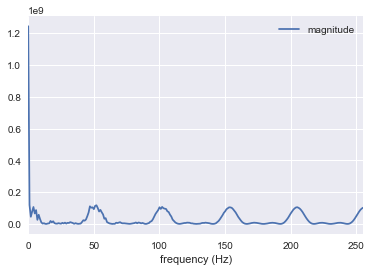

In [10]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = np.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.waves[20])
ps.plot(x='frequency (Hz)')

In [11]:
ps.head()

,frequency (Hz),magnitude
0,0.0,1.243127e+09
1,1.0,1.187992e+08
2,2.0,4.489512e+07
3,3.0,7.722466e+07
4,4.0,1.064968e+08


In [12]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

# bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

In [13]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.waves.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

In [14]:
X_train = to_features(dataset)
# features = np.concatenate([relax_features, math_features])
assert np.all( [ len(feat) == 256 for feat in X_train ] )
X_test = to_features(datasetTest)

In [15]:
assert X_train.shape[0] == Y_train.shape[0]
X_train.shape, Y_train.shape # just a check that everything has the right size


((540, 256), (540,))

In [16]:
assert X_test.shape[0] == Y_test.shape[0]
X_test.shape, Y_test.shape # just a check that everything has the right size

((600, 256), (600,))

In [18]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [19]:
# X_train, X_validate, Y_train, Y_validate = sklearn.model_selection.train_test_split(
#     X_train, Y_train, 
#     test_size=0.33, random_state=42)

# clf, cvres = xgb_cross_validate(X_train, Y_train)

NameError: name 'fresh_clf' is not defined

In [ ]:
clf.score(X_test, Y_test)

In [20]:
print(len(X_train))
print(len(Y_train))

540
540


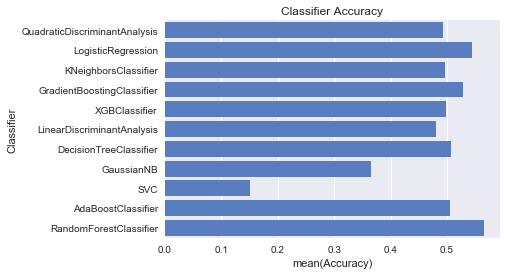

In [21]:
log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

acc_dict = {}

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier()]

# X_train, X_validate, Y_train, Y_validate = sklearn.model_selection.train_test_split(
#     X_train, Y_train, 
#     test_size=1/3, random_state=42)

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, Y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(Y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf]
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

LR: 0.455556 (0.094861)
LDA: 0.405556 (0.068519)
KNN: 0.398148 (0.032341)
CART: 0.438889 (0.071746)
XGB: 0.368519 (0.047898)
SVM: 0.000000 (0.000000)
RFC: 0.385185 (0.143635)
ABC: 0.398148 (0.044018)
GBC: 0.362963 (0.069881)


/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carinasauter/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are col

QDA: 0.000000 (0.000000)


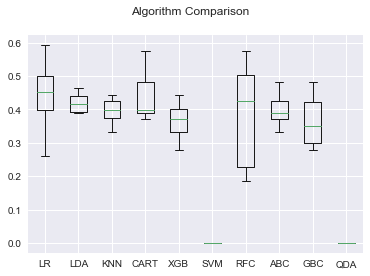

In [22]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('XGB',  XGBClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [26]:
rfc_classifier = RandomForestClassifier()
rfc_classifier.fit(X_train, Y_train)
result = rfc_classifier.score(X_test, Y_test)
result

0.57666666666666666

In [24]:
rcParams['figure.figsize'] = 12, 4

target = 'Disbursed'
IDcol = 'ID'

import plotly as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [25]:
def modelfit(alg, X_train, Y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label= Y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train ,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : " + str(metrics.accuracy_score(Y_train, dtrain_predictions)))
    print ("AUC Score (Train): " + str(metrics.roc_auc_score(Y_train, dtrain_predprob)))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.996111111111
AUC Score (Train): 1.0


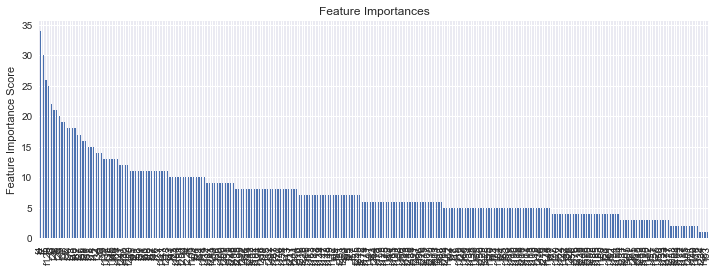

In [18]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, Y_train)

In [19]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.53046, std: 0.04686, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.53273, std: 0.05005, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.53166, std: 0.04594, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.53883, std: 0.05300, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.55332, std: 0.05276, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.52712, std: 0.05530, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.54679, std: 0.05817, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.53198, std: 0.04850, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.52823, std: 0.06343, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.54409, std: 0.04882, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.54942, std: 0.05870, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.53039, std: 0.05684, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3

In [20]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.55586, std: 0.06685, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.51204, std: 0.05620, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.52683, std: 0.05215, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.53782, std: 0.05080, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.55332, std: 0.05276, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.52901, std: 0.05445, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.53946, std: 0.05725, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.53919, std: 0.04777, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.53027, std: 0.04682, params: {'max_depth': 6, 'min_child_weight': 4}],
 {'max_depth': 4, 'min_child_weight': 2},
 0.5558581457274269)

In [ ]:
#best max_depth = 4 and best min_child_weight = 2

In [25]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.55586, std: 0.06685, params: {'gamma': 0.0},
  mean: 0.53658, std: 0.05765, params: {'gamma': 0.1},
  mean: 0.54613, std: 0.05182, params: {'gamma': 0.2},
  mean: 0.54938, std: 0.04424, params: {'gamma': 0.3},
  mean: 0.54539, std: 0.04151, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.5558581457274269)


Model Report
Accuracy : 0.863333333333
AUC Score (Train): 0.958311546841


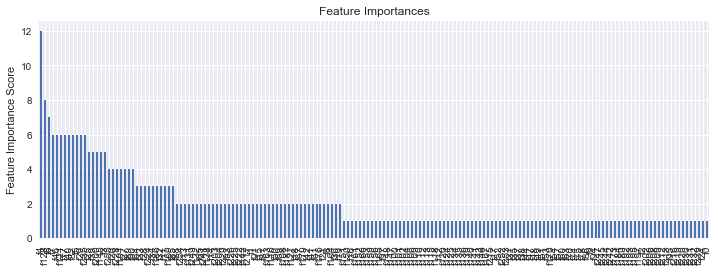

In [23]:
 xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train,Y_train)

In [26]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.54746, std: 0.05260, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.54713, std: 0.05837, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.54041, std: 0.06581, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.54000, std: 0.05300, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.52272, std: 0.07418, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.54540, std: 0.06184, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.54061, std: 0.04827, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.53158, std: 0.05432, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.51881, std: 0.04255, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.54789, std: 0.05976, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.55357, std: 0.06943, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.54310, std: 0.05139, params: {'colsample_bytree': 0.8, 'subsample'

In [29]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.75, 0.8, 0.85], 'subsample': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.53637, std: 0.04968, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.52777, std: 0.05319, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.54562, std: 0.06296, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.52421, std: 0.05579, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.55357, std: 0.06943, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.52892, std: 0.05933, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.53302, std: 0.05741, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.54063, std: 0.05224, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.53636, std: 0.08025, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.5535705640280804)

In [32]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.55357, std: 0.06943, params: {'reg_alpha': 1e-05},
  mean: 0.54857, std: 0.06535, params: {'reg_alpha': 0.01},
  mean: 0.53643, std: 0.04753, params: {'reg_alpha': 0.1},
  mean: 0.54175, std: 0.04629, params: {'reg_alpha': 1},
  mean: 0.50261, std: 0.02998, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.5535705640280804)


Model Report
Accuracy : 0.863333333333
AUC Score (Train): 0.958311546841


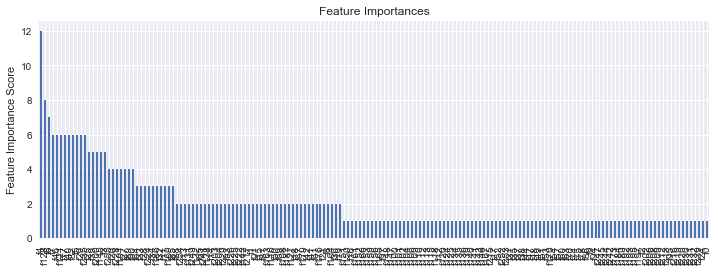

In [33]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, Y_train)

In [37]:
np.unique(xgb3.predict(X_test))

array([0])

In [61]:
thought = dataset[dataset['labels'] == 1]
notthought = dataset[dataset['labels'] == 0]
notthought.reset_index(drop=True)
notthoughtsample = notthought.sample(270, replace=False, weights=None)
stratified_df = thought.append(notthoughtsample, ignore_index = True, verify_integrity=True)
dataset = stratified_df

In [62]:
len(stratified_df)

540